In [2]:
# Statistical Arbitrage - Pair Trading Strategy
import pandas as pd
import numpy as np
from binance.client import Client # pip install python-binance
import math
import os.path
import time
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm_notebook #(Optional, used for progress-bars)
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

In [ ]:
# client login to binance.us
binance_client = Client(os.getenv('binance_api'), os.getenv('binance_secret'))
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

In [ ]:
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2017', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

def get_all_binance(symbol, kline_size, save = False):
    filename = '../statarb/data/%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df= pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2017', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    for line in klines:
        del line[6:]
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    data['symbol'] = symbol
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [ ]:
# valid intervals - 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w, 1M
# saves all files in /data directory
interval = '1d'

binance_symbols = []
tickers = binance_client.get_all_tickers()
for item in tickers:
        binance_symbols.append(item['symbol'])
for symbol in binance_symbols:
    get_all_binance(symbol, interval, save = True)

In [1]:
globbed_files = glob.glob("../statarb/data/*.csv") #creates a list of all csv files

data = [] # pd.concat takes a list of dataframes as an agrument
for csv in globbed_files:
    frame = pd.read_csv(csv)
    data.append(frame)

combined_data = pd.concat(data, ignore_index=True) #dont want pandas to try an align row indexes
combined_data.to_csv('combined_data.csv', index=False, encoding='utf-8-sig') #export to csv

NameError: name 'glob' is not defined

In [22]:
constant_pair = 'USDT' # to elimante reduncies pick one pair
start_date = '2021-01-01'
end_date = '2021-02-15'
batch = 50 # theres over 400 trading symbols on binance, this is the top 50 by volume for liquidity reasons
disregard = ['DOWN', 'BUSD'] 
pattern = '|'.join(disregard)

df = pd.read_csv('combined_data.csv')
df.set_index('timestamp', inplace=True)
df = df[['symbol', 'close', 'volume']]
df = df[df['symbol'].str.contains(constant_pair)]

mask = (df.index > start_date) & (df.index <= end_date)
df = df.loc[mask]
limit = len(df[df['symbol'] == 'ETHUSDT'])
counts = df['symbol'].value_counts()
df = df[~df['symbol'].isin(counts[counts < limit].index)]

by_volume = df.groupby('symbol')['volume'].mean().nlargest(batch)
by_volume = (by_volume.index).tolist()
df = df[df['symbol'].isin(by_volume)]
df = df[['symbol', 'close']]
df = df.loc[~df['symbol'].str.contains(pattern)]

In [23]:
df = df.pivot_table(index='timestamp', columns='symbol', values='close') # converts table for correlation analysis
df.head()

symbol,ADAUSDT,AKROUSDT,ANKRUSDT,BTTUSDT,CELRUSDT,CHZUSDT,COSUSDT,DENTUSDT,DOGEUSDT,DREPUSDT,...,STMXUSDT,TFUELUSDT,TROYUSDT,TRXUSDT,VETUSDT,VTHOUSDT,WINUSDT,XLMUSDT,XRPUSDT,ZILUSDT
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-02,0.17742,0.009032,0.008557,0.000337,0.00480,0.019256,0.00767,0.000204,0.010526,0.004799,...,0.002433,0.037912,0.002584,0.02721,0.019993,0.000704,0.000060,0.12751,0.22064,0.07219
2021-01-03,0.20615,0.010030,0.008610,0.000313,0.00538,0.019518,0.00764,0.000220,0.009821,0.005115,...,0.002422,0.032107,0.002746,0.02949,0.026226,0.000796,0.000066,0.13653,0.22540,0.06763
2021-01-04,0.22528,0.009586,0.008397,0.000314,0.00566,0.018871,0.00769,0.000219,0.009761,0.004875,...,0.002548,0.029352,0.002729,0.03095,0.024598,0.000747,0.000071,0.16404,0.23565,0.06998
2021-01-05,0.25873,0.009423,0.008499,0.000310,0.00592,0.020074,0.00773,0.000214,0.009970,0.004823,...,0.002421,0.030090,0.002805,0.02852,0.027964,0.000805,0.000067,0.19291,0.22573,0.07023
2021-01-06,0.33309,0.010354,0.009151,0.000324,0.00704,0.021122,0.00784,0.000233,0.010420,0.004808,...,0.002623,0.030533,0.002820,0.03046,0.030819,0.000817,0.000073,0.33938,0.24854,0.07772


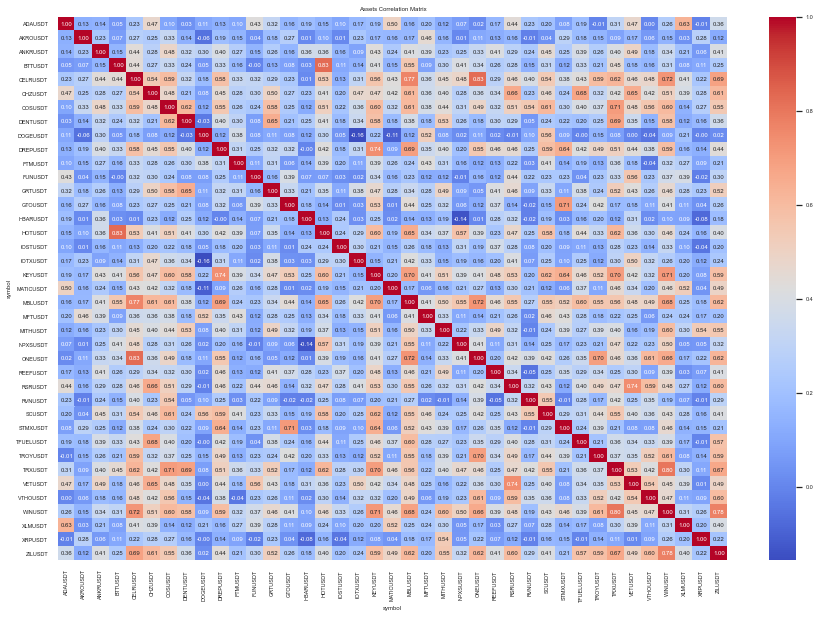

In [24]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(15,10))
sns.set(font_scale=0.5)
sns.heatmap(df.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=300, bbox_inches='tight')

[('ADAUSDT', 'COSUSDT'), ('ADAUSDT', 'KEYUSDT'), ('ADAUSDT', 'MITHUSDT'), ('ADAUSDT', 'NPXSUSDT'), ('ADAUSDT', 'TROYUSDT'), ('ADAUSDT', 'VTHOUSDT'), ('ADAUSDT', 'WINUSDT'), ('AKROUSDT', 'GTOUSDT'), ('AKROUSDT', 'KEYUSDT'), ('AKROUSDT', 'MFTUSDT'), ('AKROUSDT', 'XRPUSDT'), ('ANKRUSDT', 'CELRUSDT'), ('ANKRUSDT', 'CHZUSDT'), ('ANKRUSDT', 'GRTUSDT'), ('ANKRUSDT', 'IOTXUSDT'), ('ANKRUSDT', 'MITHUSDT'), ('ANKRUSDT', 'RVNUSDT'), ('ANKRUSDT', 'TFUELUSDT'), ('ANKRUSDT', 'TROYUSDT'), ('BTTUSDT', 'DOGEUSDT'), ('BTTUSDT', 'GRTUSDT'), ('BTTUSDT', 'MATICUSDT'), ('BTTUSDT', 'MBLUSDT'), ('BTTUSDT', 'TFUELUSDT'), ('BTTUSDT', 'TRXUSDT'), ('BTTUSDT', 'VTHOUSDT'), ('BTTUSDT', 'XLMUSDT'), ('BTTUSDT', 'XRPUSDT'), ('BTTUSDT', 'ZILUSDT'), ('CELRUSDT', 'CHZUSDT'), ('CELRUSDT', 'COSUSDT'), ('CELRUSDT', 'GRTUSDT'), ('CELRUSDT', 'MATICUSDT'), ('CELRUSDT', 'MBLUSDT'), ('CELRUSDT', 'MITHUSDT'), ('CELRUSDT', 'RVNUSDT'), ('CELRUSDT', 'STMXUSDT'), ('CELRUSDT', 'TFUELUSDT'), ('CELRUSDT', 'WINUSDT'), ('CHZUSDT', 'COSUSD

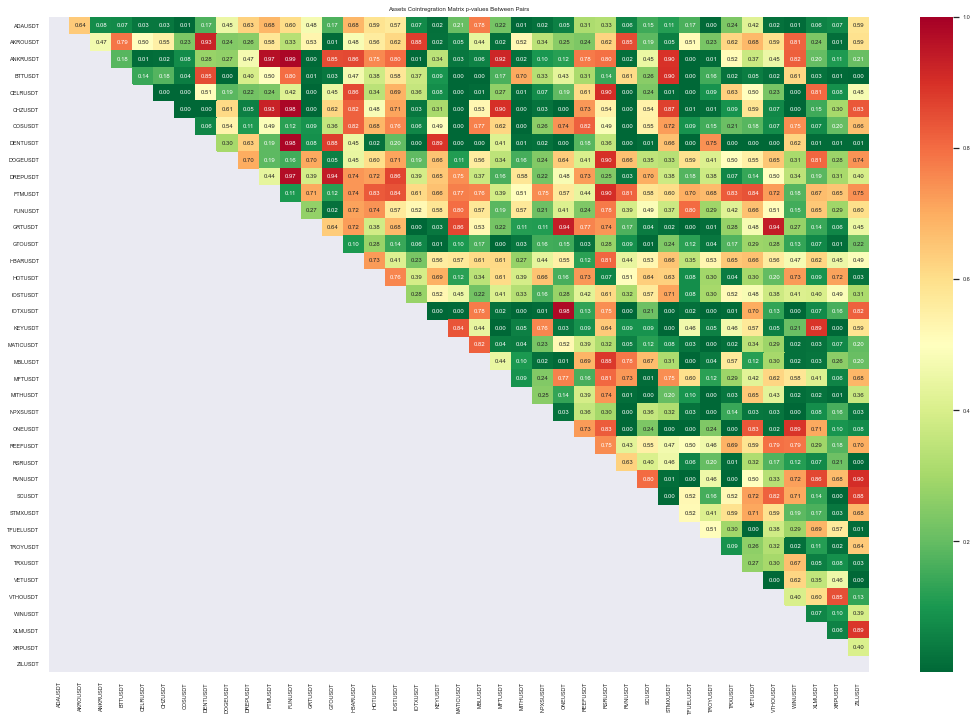

In [25]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.03: # set p-value threshold
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(df)
print(pairs)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(pvalues, xticklabels = df.columns,
                yticklabels = df.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointregration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=300, bbox_inches='tight')

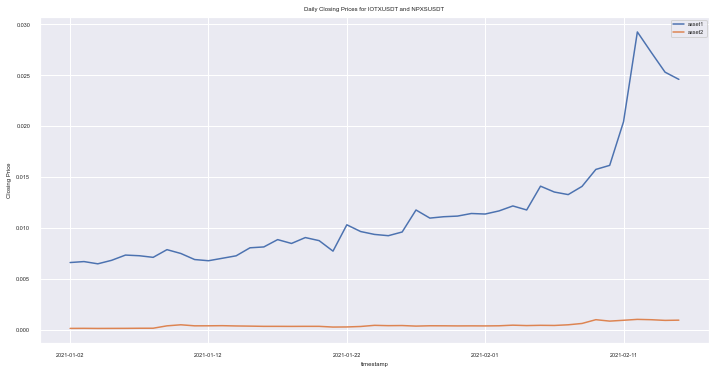

In [26]:
# final pair to test strategy
asset1 = 'IOTXUSDT'
asset2 = 'NPXSUSDT'

# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = df[asset1]
train['asset2'] = df[asset2]

# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(12, 6), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
ax.grid(True);
plt.savefig('chart3', dpi=300)

Hedge Ratio =  0.041393444495335704


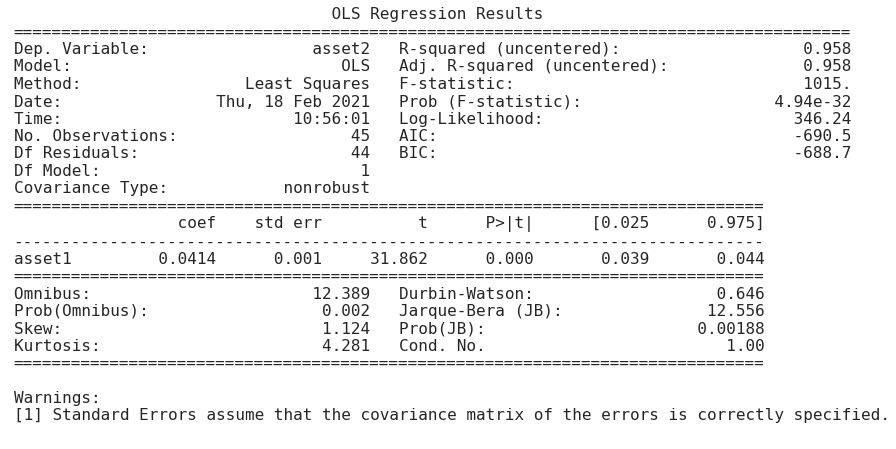

In [27]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

# print regression summary results
plt.rc('figure', figsize=(15,10))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=300);
print('Hedge Ratio = ', model.params[0])

Critical Value =  -3.6083202868454713
{'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}


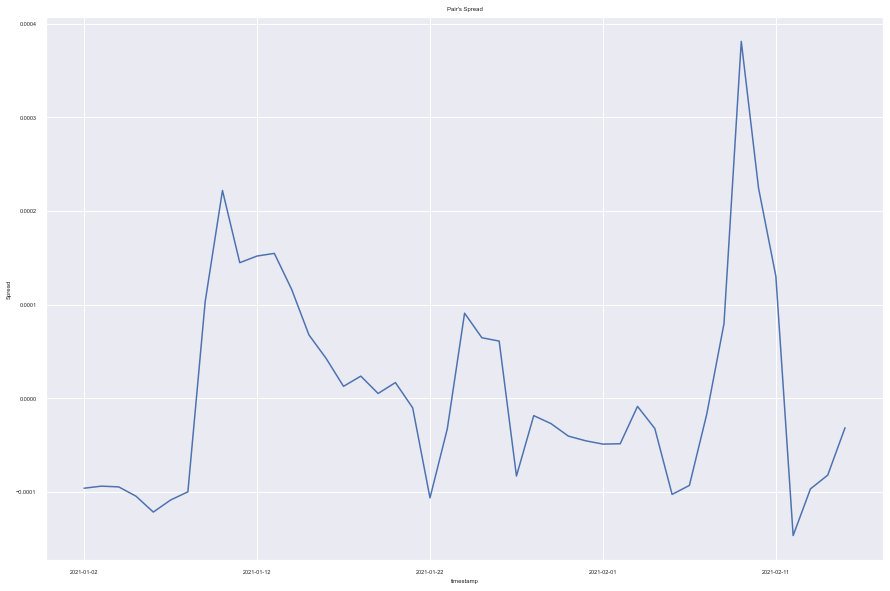

In [28]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

# Plot the spread
ax = spread.plot(figsize=(15,10), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);

# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
print('Critical Value = ', adf[0])

# probablity critical values
print(adf[4])

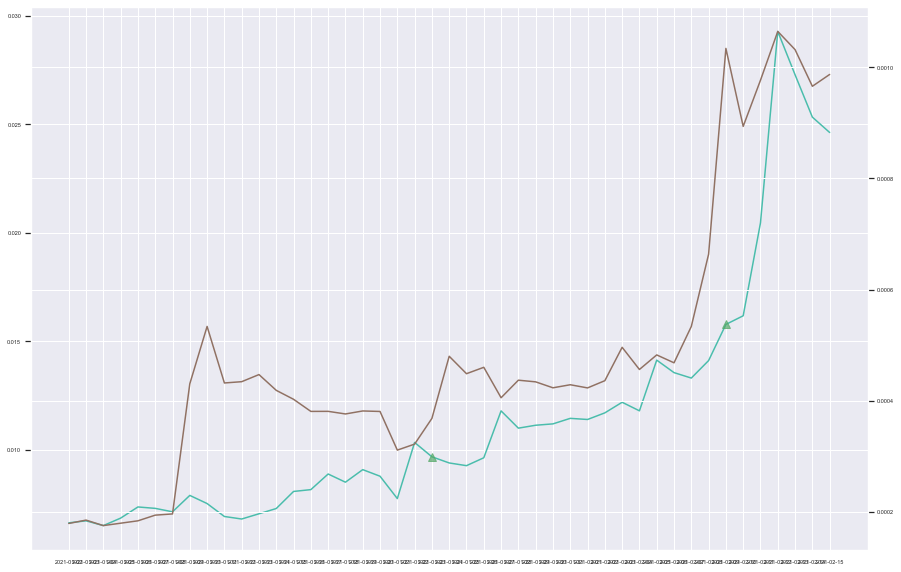

In [29]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = df[asset1] 
signals['asset2'] = df[asset2]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# verify datafame head and tail
signals.head(3).append(signals.tail(3))

# visualize trading signals and position
fig = plt.figure(figsize=(15,10))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

In [30]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()
portfolio.index = pd.to_datetime(portfolio.index)
portfolio

,asset1,holdings1,cash1,total asset1,return1,positions1,asset2,holdings2,cash2,total asset2,return2,positions2,z,total asset,z upper limit,z lower limit
timestamp,,,,,,,,,,,,,,,,
2021-01-04,0.006516,0.0000,100000.0000,100000.0000,0.000000,0.0,0.000175,0.000000,100000.000000,100000.000000,0.000000e+00,0.0,1.777828,200000.000000,1.0,-1.0
2021-01-05,0.006860,0.0000,100000.0000,100000.0000,0.000000,0.0,0.000179,0.000000,100000.000000,100000.000000,0.000000e+00,0.0,1.931427,200000.000000,1.0,-1.0
2021-01-06,0.007374,0.0000,100000.0000,100000.0000,0.000000,0.0,0.000184,0.000000,100000.000000,100000.000000,0.000000e+00,0.0,2.216502,200000.000000,1.0,-1.0
2021-01-07,0.007309,0.0000,100000.0000,100000.0000,0.000000,0.0,0.000194,0.000000,100000.000000,100000.000000,0.000000e+00,0.0,1.849692,200000.000000,1.0,-1.0
2021-01-08,0.007151,0.0000,100000.0000,100000.0000,0.000000,0.0,0.000196,0.000000,100000.000000,100000.000000,0.000000e+00,0.0,1.665566,200000.000000,1.0,-1.0
2021-01-09,0.007906,54024.8604,45975.1396,100000.0000,0.000000,2.0,0.000430,-80822.689610,180822.689610,100000.000000,0.000000e+00,-2.0,-1.046873,200000.000000,1.0,-1.0
2021-01-10,0.007531,51462.3354,45975.1396,97437.4750,-0.025625,0.0,0.000534,-100225.394320,180822.689610,80597.295290,-1.940270e-01,0.0,-1.684816,178034.770290,1.0,-1.0
2021-01-11,0.006935,47389.6290,45975.1396,93364.7686,-0.041798,0.0,0.000432,-81104.432660,180822.689610,99718.256950,2.372407e-01,0.0,-1.393210,193083.025550,1.0,-1.0
2021-01-12,0.006819,46596.9546,45975.1396,92572.0942,-0.008490,0.0,0.000434,-81536.438670,180822.689610,99286.250940,-4.332266e-03,0.0,-1.445974,191858.345140,1.0,-1.0


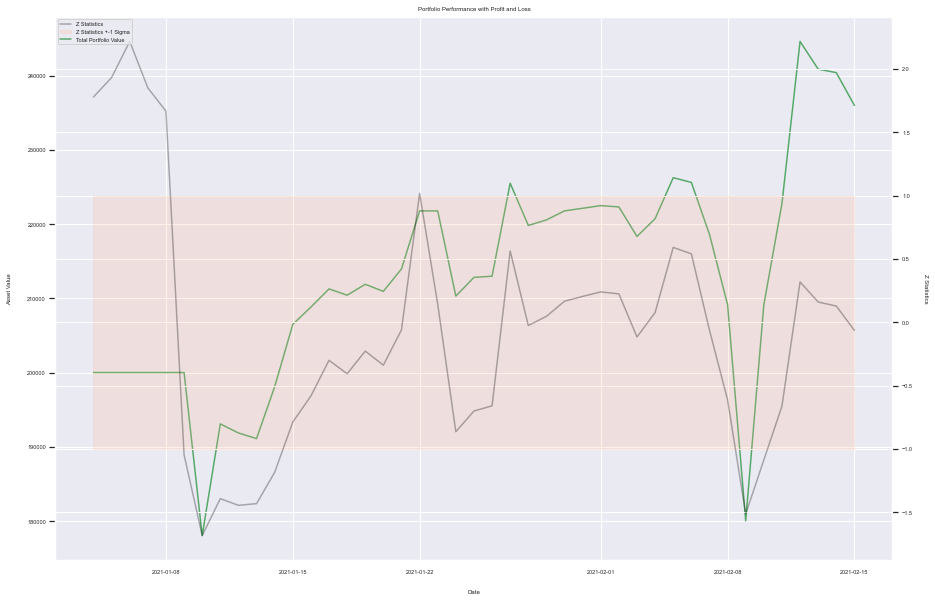

In [31]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(15,10),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=300);

In [32]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0]).days
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

Number of days =  42
CAGR = 173881.057%
